# Projet: Uber Pickups using DBSCAN  15 oct 2021
**<p>Author: Said SOUFYAN</p>**

# EDA and exploring Data

**Install necessary Packages**

In [1]:
!pip install plotly==4.9.0
!pip install jupyterlab "ipywidgets>=7.5"


import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe_connected"
import plotly.graph_objects as go

  Using cached plotly-4.9.0-py2.py3-none-any.whl (12.9 MB)
Processing /home/jovyan/.cache/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56/retrying-1.3.3-py3-none-any.whl
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


**Reading Data**

In [2]:
data= pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14.csv")
#data = pd.read_csv('src/uber-raw-data-sep14.csv')
print('Set with labels (our train+test) :', data.shape)
data.drop("Base",inplace=True, axis=1)

data.head(5)

Set with labels (our train+test) : (564516, 4)


,Date/Time,Lat,Lon
0,4/1/2014 0:11:00,40.7690,-73.9549
1,4/1/2014 0:17:00,40.7267,-74.0345
2,4/1/2014 0:21:00,40.7316,-73.9873
3,4/1/2014 0:28:00,40.7588,-73.9776
4,4/1/2014 0:33:00,40.7594,-73.9722


**Sampling data and feature engineering**

In [3]:
data =data.sample(10000)

In [4]:
data['Dayofweek'] = pd.to_datetime(data['Date/Time']).dt.dayofweek
data.drop("Date/Time",inplace=True, axis=1)

In [5]:
data[5:]

,Lat,Lon,Dayofweek
327300,40.7773,-73.9623,1
510377,40.7321,-74.0037,4
359289,40.7500,-73.9938,4
254571,40.7495,-73.9922,3
414537,40.7395,-74.0054,4
...,...,...,...
55497,40.7832,-73.9762,4
17415,40.7533,-73.9845,1
282259,40.7293,-74.0011,4
282481,40.7339,-73.9900,4


<AxesSubplot:xlabel='Dayofweek', ylabel='countPicks'>

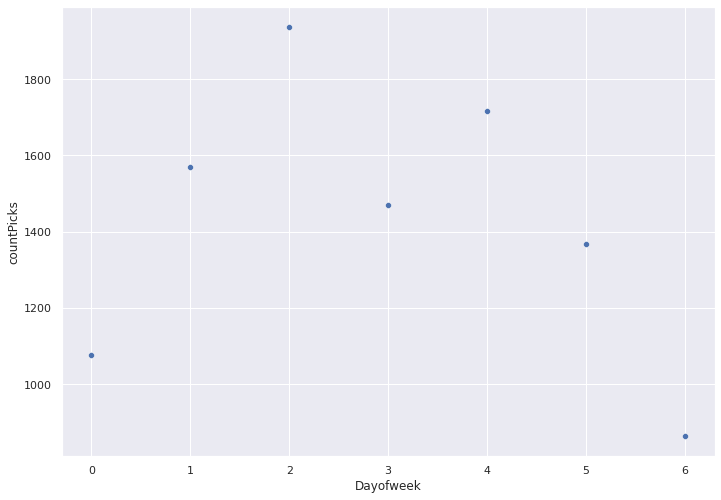

In [17]:
gr= data.groupby("Dayofweek").agg(
    countPicks=pd.NamedAgg(column="Lat", aggfunc="count")).reset_index()

sns.scatterplot(data=gr, x="Dayofweek", y="countPicks")

# Making model

In [6]:
sc=StandardScaler()
X = sc.fit_transform(data)

In [8]:
# On ré-entraîne un KMeans avec le nombre optimal de clusters
dbscan = DBSCAN(eps=0.6, min_samples=20)
dbscan.fit(X)

DBSCAN(eps=0.6, min_samples=20)

**Clustering each pickup**

In [9]:
data.loc[:,'Cluster_dbscan'] = dbscan.fit_predict(X)

In [10]:
np.unique(dbscan.labels_,return_counts=True)

(array([-1,  0,  1,  2,  3]), array([ 267, 9253,  194,  220,   66]))

In [11]:
data

,Lat,Lon,Dayofweek,Cluster_dbscan
191374,40.6869,-73.9777,0,0
79047,40.7277,-74.0074,2,0
562522,40.7719,-73.9592,4,0
129592,40.7288,-73.9951,4,0
372888,40.7641,-73.9750,6,0
...,...,...,...,...
55497,40.7832,-73.9762,4,0
17415,40.7533,-73.9845,1,0
282259,40.7293,-74.0011,4,0
282481,40.7339,-73.9900,4,0


**Mapping of result in 2d maps**

In [12]:
mask = data["Cluster_dbscan"] != -1
fig = px.scatter_mapbox(data[mask], lat="Lat", lon="Lon",   size_max=15, zoom=10, color='Cluster_dbscan')

fig.update_layout(mapbox_style="carto-positron")
fig.show()

In [13]:
mask2 = data["Cluster_dbscan"]<5
filt = data[mask2]
res =filt.groupby(['Cluster_dbscan','Dayofweek']).size().reset_index(name='counts')
res.head(10)


,Cluster_dbscan,Dayofweek,counts
0,-1,0,33
1,-1,1,39
2,-1,2,32
3,-1,3,36
4,-1,4,44
5,-1,5,59
6,-1,6,24
7,0,0,947
8,0,1,1455
9,0,2,1840


<AxesSubplot:xlabel='Dayofweek', ylabel='counts'>

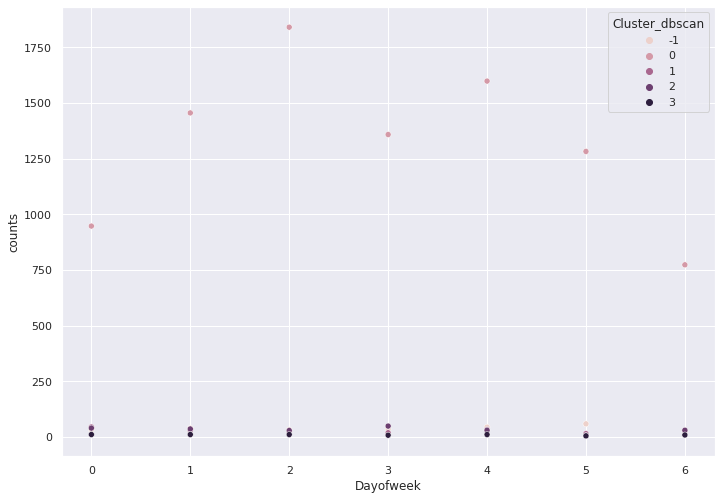

In [14]:
palette = {0:"tab:cyan",
           1:"tab:orange", 
           2:"tab:purple"}
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=res,x=res["Dayofweek"],y=res["counts"],hue='Cluster_dbscan')